In [14]:
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
import random
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, accuracy_score, roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1 - EDA

Renamed test directory as predict

Renamed val directory as test

### Data distribution

Check the distribution of images between the fractured and not fractured categories in the training, test and predict sets.

In [2]:
# Define the paths
train_dir = 'bone-frature/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train'
test_dir = 'bone-frature/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test'
predict_dir = 'bone-frature/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/predict'

# Function to count files in each category
def count_files(directory):
    fractured_count = len(os.listdir(os.path.join(directory, 'fractured')))
    not_fractured_count = len(os.listdir(os.path.join(directory, 'not fractured')))
    return fractured_count, not_fractured_count

train_counts = count_files(train_dir)
test_counts = count_files(test_dir)
predict_counts = count_files(predict_dir)

print(f"Training set - Fractured: {train_counts[0]}, Not Fractured: {train_counts[1]}")
print(f"Test set - Fractured: {test_counts[0]}, Not Fractured: {test_counts[1]}")
print(f"Predict set - Fractured: {predict_counts[0]}, Not Fractured: {predict_counts[1]}")


Training set - Fractured: 4606, Not Fractured: 4640
Test set - Fractured: 337, Not Fractured: 492
Predict set - Fractured: 238, Not Fractured: 268


Plot the distributions

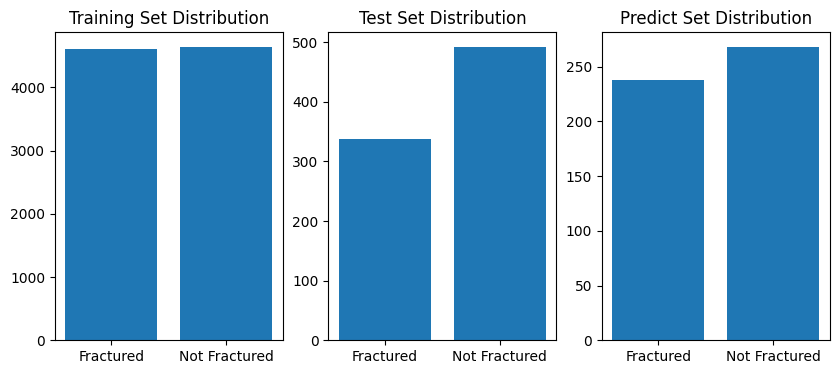

In [3]:
labels = ['Fractured', 'Not Fractured']
train_counts = count_files(train_dir)
test_counts = count_files(test_dir)
predict_counts = count_files(predict_dir)

# Training set distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.bar(labels, train_counts)
plt.title('Training Set Distribution')

# Test set distribution
plt.subplot(1, 3, 2)
plt.bar(labels, test_counts)
plt.title('Test Set Distribution')

plt.subplot(1, 3, 3)
plt.bar(labels, predict_counts)
plt.title('Predict Set Distribution')
plt.show()

We observe a slight imbalance in the test and predict set but nothing of great magnitude.

### Image analysis

Check the dimensions of a few images and visualize them

In [4]:
def get_image_sizes(directory):
    sizes = []
    for category in ['fractured', 'not fractured']:
        folder = os.path.join(directory, category)
        for filename in os.listdir(folder):
            img = Image.open(os.path.join(folder, filename))
            sizes.append(img.size)
    return sizes

train_image_sizes = get_image_sizes(train_dir)
print("Sample image sizes from training set:", train_image_sizes[:5])

Sample image sizes from training set: [(617, 1024), (2328, 2928), (761, 1024), (408, 1024), (1517, 2021)]


Here we see different image sizes, meaning resizing will be necessary

Let's show some images first

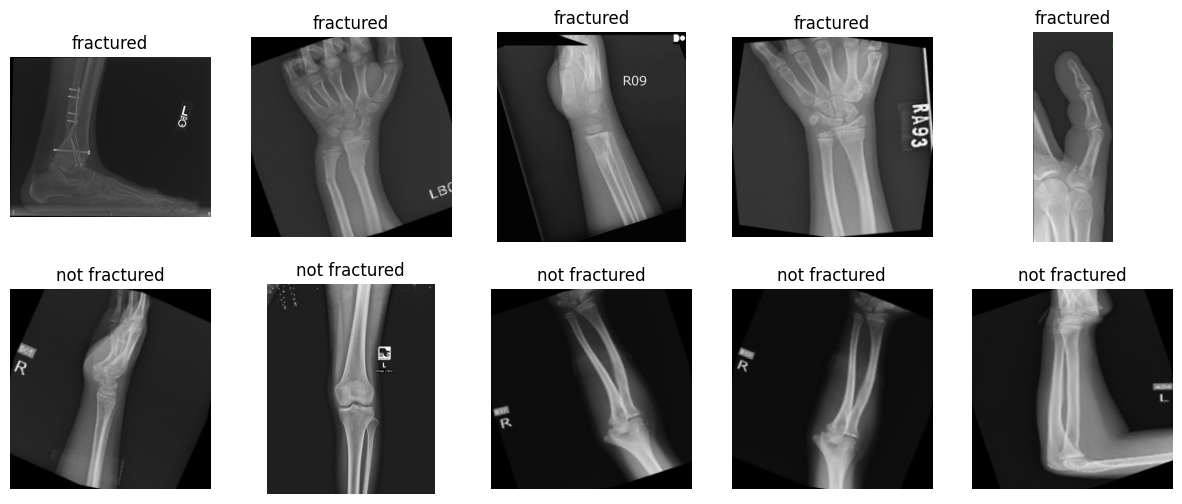

In [5]:
def show_sample_images(directory):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    categories = ['fractured', 'not fractured']
    for i, category in enumerate(categories):
        folder = os.path.join(directory, category)
        filenames = random.sample(os.listdir(folder), 5)
        for j, filename in enumerate(filenames):
            img = Image.open(os.path.join(folder, filename))
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title(category)
    plt.show()

show_sample_images(train_dir)

### Plotting data augmentation

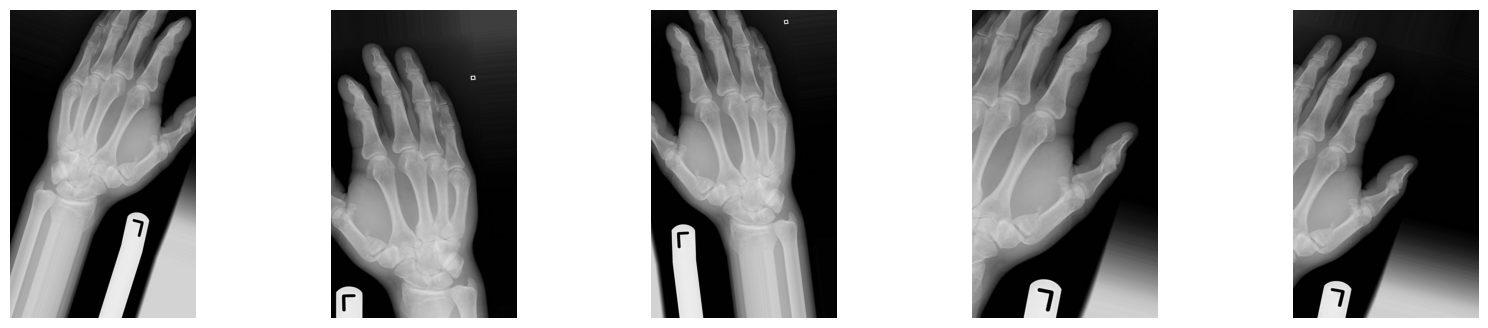

In [6]:
# Load a sample image
img = Image.open(os.path.join(train_dir, 'fractured', os.listdir(os.path.join(train_dir, 'fractured'))[0]))

# Convert image to numpy array and normalize to range [0, 1]
img_array = np.array(img) / 255.0

# Ensure the image has 3 channels (RGB)
if len(img_array.shape) == 2:
    img_array = np.stack((img_array,) * 3, axis=-1)
elif img_array.shape[2] == 1:
    img_array = np.concatenate((img_array, img_array, img_array), axis=-1)

# Reshape to add batch dimension
img_array = img_array.reshape((1,) + img_array.shape)

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a grid of augmented images
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axes.flat):
    augmented_img = next(datagen.flow(img_array, batch_size=1))[0]
    ax.imshow(augmented_img)
    ax.axis('off')
plt.show()

Above is a random image augmented

# Data preprocessing

Here are the 5 steps chosen to take
1. Loading images
2. Grayscale conversion
3. Resizing to 150x150 with padding to keep the aspect ratio
4. Normalizing pixel from [-1 , 1]
5. Data augmentation on the training set only

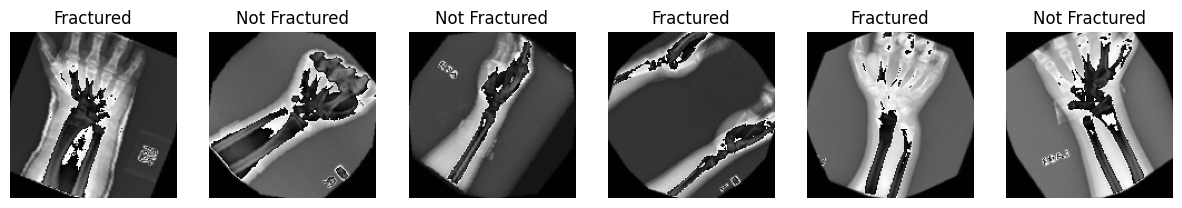

In [7]:
# To handle truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Custom dataset class to handle loading and preprocessing
class XRayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        for label, category in enumerate(['fractured', 'not fractured']):
            category_dir = os.path.join(root_dir, category)
            for img_name in os.listdir(category_dir):
                self.image_paths.append(os.path.join(category_dir, img_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('L')  # Convert to grayscale
        except (IOError, OSError) as e:
            print(f"Skipping corrupted image: {img_path}")
            return self.__getitem__((idx + 1) % len(self.image_paths))
        
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define the transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = XRayDataset(train_dir, transform=train_transform)
test_dataset = XRayDataset(test_dir, transform=test_transform)
predict_dataset = XRayDataset(predict_dir, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
predict_loader = DataLoader(predict_dataset, batch_size=32, shuffle=False)

# Function to visualize some images
def show_sample_images(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    fig, axes = plt.subplots(1, 6, figsize=(15, 6))
    for i in range(6):
        ax = axes[i]
        img = transforms.ToPILImage()(images[i])
        ax.imshow(img, cmap='gray')
        ax.set_title('Fractured' if labels[i] == 0 else 'Not Fractured')
        ax.axis('off')
    plt.show()

# Show sample images from the train loader
show_sample_images(train_loader)

# Building the CNN model

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 37 * 37, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Check if GPU is available and use it, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model instance and move it to the appropriate device
model = SimpleCNN().to(device)

# Print the model summary
summary(model, input_size=(1, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]             640
         MaxPool2d-2           [-1, 64, 75, 75]               0
            Conv2d-3           [-1, 32, 75, 75]          18,464
         MaxPool2d-4           [-1, 32, 37, 37]               0
           Flatten-5                [-1, 43808]               0
            Linear-6                   [-1, 64]       2,803,776
            Linear-7                    [-1, 1]              65
Total params: 2,822,945
Trainable params: 2,822,945
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.09
Forward/backward pass size (MB): 15.78
Params size (MB): 10.77
Estimated Total Size (MB): 26.63
----------------------------------------------------------------


# Training the model

In [9]:
# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training loop

In [10]:
num_epochs = 70
validation_loss_threshold = 0.05  # Set your desired threshold
patience = 0  # Number of epochs to wait before stopping
patience_counter = 0

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Validation step
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)

    # Print average training and validation loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {avg_train_loss}  Validation Loss: {avg_val_loss}")

    # Early stopping condition
    if avg_val_loss < validation_loss_threshold:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Stopping early at epoch {epoch+1} as validation loss {avg_val_loss} is below threshold {validation_loss_threshold} for {patience} consecutive epochs.")
            break
    else:
        patience_counter = 0


C:\Users\drago\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Loss: 0.5483041675342408  Validation Loss: 0.447900668073159
Epoch 2, Loss: 0.20115657479447477  Validation Loss: 0.2986008862320047
Epoch 3, Loss: 0.08976495879215662  Validation Loss: 0.222659019422001
Epoch 4, Loss: 0.05587371143473757  Validation Loss: 0.19950482066297598
Epoch 5, Loss: 0.04704720938214098  Validation Loss: 0.1928126003163365
Epoch 6, Loss: 0.037755029527172385  Validation Loss: 0.1638393446941896
Epoch 7, Loss: 0.03145597914151628  Validation Loss: 0.1414820642284422
Epoch 8, Loss: 0.023732738410465897  Validation Loss: 0.10352302396775205
Epoch 9, Loss: 0.05436849639911944  Validation Loss: 0.6470064451762553
Epoch 10, Loss: 0.06832412152986564  Validation Loss: 0.5875661791564758
Epoch 11, Loss: 0.05566098921465813  Validation Loss: 0.12252469449581091
Epoch 12, Loss: 0.018810674618642817  Validation Loss: 0.0913466085926652
Epoch 13, Loss: 0.0212814703336083  Validation Loss: 0.1258339171647374
Epoch 14, Loss: 0.016742791300265892  Validation Loss: 0.0

Model testing

In [11]:
# Evaluate on the test set
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        test_loss += loss.item()
        
        # Calculate accuracy
        predicted = (outputs.squeeze() > 0.5).float()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
conf_matrix = confusion_matrix(all_labels, all_predictions)
roc_auc = roc_auc_score(all_labels, all_predictions)

# Print metrics
print(f"Test Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")
print(f"Confusion Matrix:\n{conf_matrix}")

C:\Users\drago\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Test Accuracy: 0.9867310012062727
Precision: 0.9800399201596807
Recall: 0.9979674796747967
F1 Score: 0.9889224572004028
ROC AUC Score: 0.9841469445851728
Confusion Matrix:
[[327  10]
 [  1 491]]


Confusion matrix

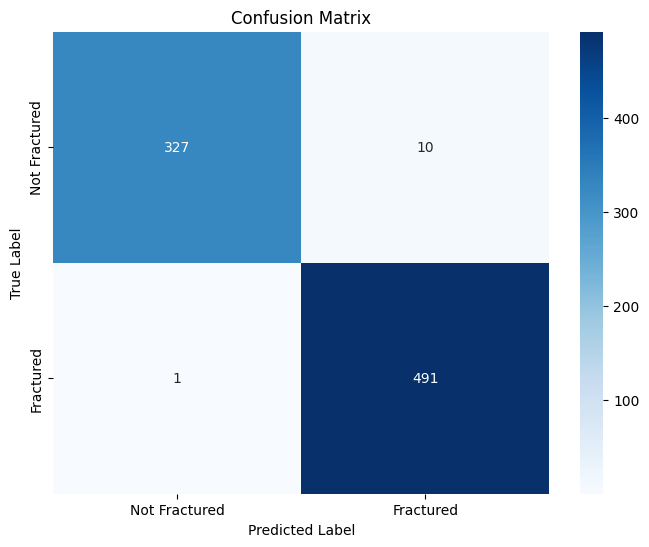

In [15]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fractured', 'Fractured'], yticklabels=['Not Fractured', 'Fractured'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

ROC Curve

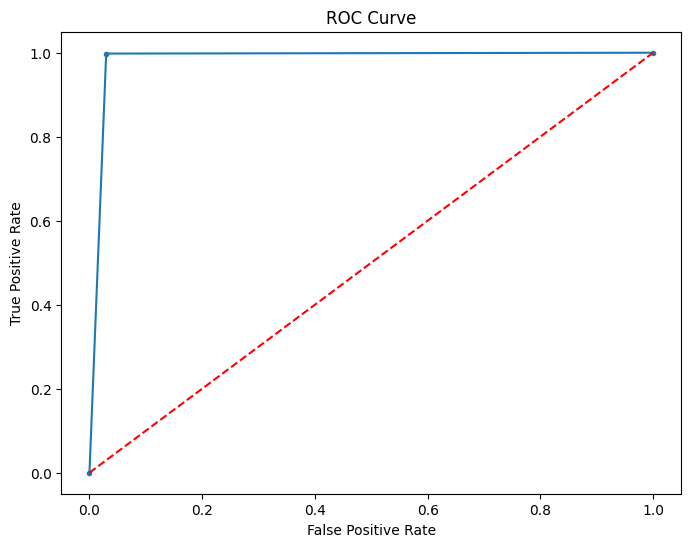

In [16]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Save the model :

In [25]:
# Save the model state dictionary
torch.save(model.state_dict(), 'bone_fracture_model_150.pth')

Let's finally predict

In [17]:
# Create a new instance of the model
loaded_model = SimpleCNN()

model_path = 'bone_fracture_model_150.pth'

# Load the state dictionary into the new model
loaded_model.load_state_dict(torch.load('bone_fracture_model_150.pth'))

# Move the model to the appropriate device
loaded_model.to(device)

# Set the model to evaluation mode
loaded_model.eval()

print("Model loaded from bone_fracture_model_150.pth")

Model loaded from bone_fracture_model_150.pth


Accuracy: 99.01185770750988%
Precision: 0.985239852398524
Recall: 0.996268656716418
F1 Score: 0.9907235621521335
ROC AUC Score: 0.989730967013671



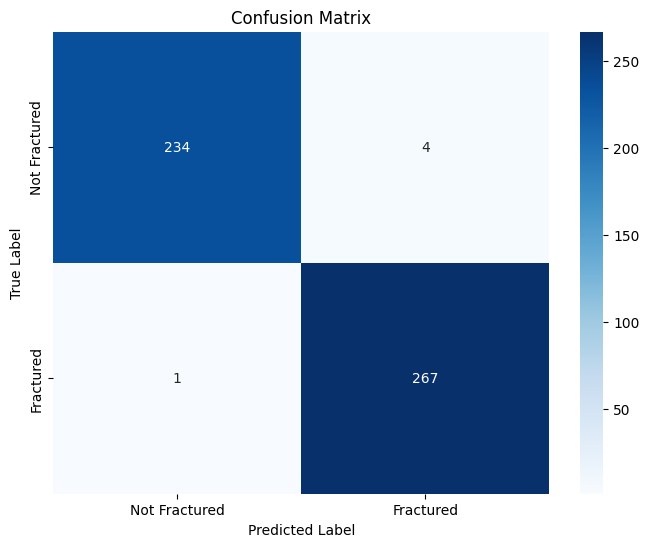


Here are all the predicted labels :
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1

In [26]:
# Make predictions
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in predict_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = loaded_model(images)
        predicted = (outputs.squeeze() > 0.5).float()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
conf_matrix = confusion_matrix(all_labels, all_predictions)
roc_auc = roc_auc_score(all_labels, all_predictions)

# Print metrics
print(f"Accuracy: {accuracy * 100}%")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")
print()
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fractured', 'Fractured'], yticklabels=['Not Fractured', 'Fractured'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print()
print('Here are all the predicted labels :')
print(all_predictions)

# Discussing the performance of the model and any potential biases or limitations

### Performance :

Quite high at the moment. Now, we could decide to include a threshold in our predictions in order to maximise recall and be almost sure to include all the true broken bones predicted as broken bones. ( only 1 image was missclassified as not being a broken bone )

That way, we would never miss a patient with a broken bone but the doctor will spend more time with cases that do not have a broken bone but are classified as if they did.


### Limitations :

Here the model is trained with Xrays only, we tested it and if you predict with a normal pipe and a broken pipe it will tell you the broken pipe is a broken bone.

Meaning that for our predicting accuracy to be in the same ballpark, we need to predict only with pictures we know are xrays of human parts.

The dataset must represent the real-world scenarios well. If the training data is not diverse enough, the model might not generalize well to unseen data.

Also, the lower the image quality, the worst the Xray has been done and if the fracture is very small or unnoticeable the less precise the model will be at predicting and we might not catch the broken bone.

### Selling point :

If a doctor's ability to identify a broken bone from an Xray is lower than 99%, then our model can help doctors identify patients with broken bones.

The model can also be used as a way for doctors to save time and only focus on individuals classified as having a broken bone.
Obviously, doctors need to listen to the patient's symptoms and pains in order to include all patients potentially at risk.

Our model predicts in less than a second if an Xray is a broken bone or not. Allowing doctors to spend less time looking at the Xray's.